In [1]:
# 파이토치 관련 라이브러리
from torchvision import datasets
from torch.utils.data import TensorDataset, DataLoader
import torch
import torch.nn as nn
import torch.optim as optim

# 마지막 그래프 출력 위한 라이브러리
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# github에서 MNIST DATASET 다운로드
!git clone https://github.com/baek2sm/ml.git
!tar -zxvf ./ml/datasets/MNIST.tar.gz

path = './'
train_dataset = datasets.MNIST(path, train=True, download=True)
test_dataset = datasets.MNIST(path, train=False, download=True)

fatal: destination path 'ml' already exists and is not an empty directory.
MNIST/
MNIST/raw/
MNIST/raw/train-labels-idx1-ubyte
MNIST/raw/t10k-labels-idx1-ubyte.gz
MNIST/raw/t10k-labels-idx1-ubyte
MNIST/raw/t10k-images-idx3-ubyte.gz
MNIST/raw/train-images-idx3-ubyte
MNIST/raw/train-labels-idx1-ubyte.gz
MNIST/raw/t10k-images-idx3-ubyte
MNIST/raw/train-images-idx3-ubyte.gz
MNIST/processed/
MNIST/processed/training.pt
MNIST/processed/test.pt


In [3]:
# 학습 세트와 테스트 세트의 입력 데이터와 타깃을 준비
X_train, y_train = train_dataset.data / 255, train_dataset.targets
X_test, y_test = test_dataset.data / 255, test_dataset.targets

# 2차원 배열을 1차원 배열로 변환
X_train, X_test = X_train.view(-1, 784), X_test.view(-1, 784)

In [4]:
train_dset = TensorDataset(X_train, y_train)
test_dset = TensorDataset(X_test, y_test)

# 데이터로더 생성
train_loader = DataLoader(train_dset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dset, batch_size=32, shuffle=False)

In [5]:
# 테스트를 위한 학습 가능한 가중치 합 activaiton function 선언
class ActivationSet(nn.Module):
    def __init__(self):
        super().__init__()
        self.ReLU = nn.ReLU()
        self.ELU = nn.ELU()
        self.GELU = nn.GELU()
        self.SiLU = nn.SiLU()
        self.functionNum = 4
        self.eps = 1e-7
        self.weight_raw = torch.nn.Parameter(torch.rand(self.functionNum))
        #self.tmp_weight = torch.nn.Parameter(torch.rand(1))


    def forward(self, x):
        self.weights = (torch.exp(self.weight_raw) + (self.eps/self.functionNum)) / torch.exp(self.weight_raw).sum()+self.eps
        #self.tmp_out = torch.stack((self.ReLU(x), self.ELU(x), self.GELU(x), self.SiLU(x)))\
        #torch.stack으로 하면 오류 나옴
        #torch.matmul(self.weights, self.tmp_out)
        self.result = self.weights[0]*self.ReLU(x) + self.weights[1]*self.ELU(x) +self.weights[2]*self.GELU(x)+self.weights[3]*self.SiLU(x)
        return self.result

In [6]:
# DNN class defination
class DNN(nn.Module):

  def __init__(self, num_features):

    super().__init__()
    # 첫 번째 은닉층을 정의
    self.hidden_layer1 = nn.Sequential(
      nn.Linear(num_features, 256),
      nn.ReLU()
    )
    # 두 번째 은닉층을 정의
    self.hidden_layer2 = nn.Sequential(
        nn.Linear(256, 128),
        nn.ReLU()
    )
    # 출력층을 정의
    self.output_layer = nn.Linear(128, 10)



  def forward(self, X):

    out = self.hidden_layer1(X)
    out = self.hidden_layer2(out)
    out = self.output_layer(out)
    return out

In [7]:
# DNN_ActivationSet class defination
class DNN_ActivationSet(nn.Module):

  def __init__(self, num_features):

    super().__init__()
    # 첫 번째 은닉층을 정의
    self.hidden_layer1 = nn.Sequential(
      nn.Linear(num_features, 256),
      ActivationSet()
    )
    # 두 번째 은닉층을 정의
    self.hidden_layer2 = nn.Sequential(
        nn.Linear(256, 128),
        ActivationSet()
    )
    # 출력층을 정의
    self.output_layer = nn.Linear(128, 10)



  def forward(self, X):

    out = self.hidden_layer1(X)
    out = self.hidden_layer2(out)
    out = self.output_layer(out)
    return out

In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'


model = DNN(784).to(device)
model_ActivationSet = DNN_ActivationSet(784).to(device)

criterion = nn.CrossEntropyLoss()
criterion_ActivationSet = nn.CrossEntropyLoss()


optimizer = optim.Adam(model.parameters(), lr=1e-4)
optimizer_ActivationSet = optim.Adam(model_ActivationSet.parameters(), lr=1e-4)

In [9]:
# 학습 함수 정의
def train(model, criterion, optimizer, loader):

  epoch_loss = 0
  epoch_acc = 0

  # 배치 학습 실행
  for X_batch, y_batch in loader:

    X_batch, y_batch = X_batch.to(device), y_batch.to(device)

    optimizer.zero_grad()

    hypothesis = model(X_batch)

    loss = criterion(hypothesis, y_batch)

    loss.backward()

    optimizer.step()

    y_predicted = torch.argmax(hypothesis, 1)
    acc = (y_predicted == y_batch).float().mean()

    epoch_loss += loss.item()
    epoch_acc += acc.item()

  # 현재 에포크의 오차와 정확도 반환
  return epoch_loss / len(loader), epoch_acc / len(loader)

In [10]:
# 평가 함수 정의
def evaluate(model, criterion, loader):

  epoch_loss = 0
  epoch_acc = 0

  with torch.no_grad():

    for X_batch, y_batch in loader:

      X_batch, y_batch = X_batch.to(device), y_batch.to(device)

      hypothesis = model(X_batch)

      loss = criterion(hypothesis, y_batch)

      y_predicted = torch.argmax(hypothesis, 1)
      acc = (y_predicted == y_batch).float().mean()

      epoch_loss += loss.item()
      epoch_acc += acc.item()

    # 현재 에포크의 오차와 정확도 반환
    return epoch_loss / len(loader), epoch_acc / len(loader)

In [11]:
history = np.zeros((0, 2))
history_ = np.zeros((0, 2))
history_ActivationSet = np.zeros((0, 2))
history__ActivationSet = np.zeros((0, 2))

# 모델 학습 진행
n_epochs = 30
for epoch in range(1, n_epochs+1):

  loss, acc = train(model, criterion, optimizer, train_loader)
  loss_ActivationSet, acc_ActivationSet = train(model_ActivationSet, criterion_ActivationSet, optimizer_ActivationSet, train_loader)

  # 모델 평가
  test_loss, test_acc = evaluate(model, criterion, test_loader)
  test_loss_ActivationSet, test_acc_ActivationSet = evaluate(model_ActivationSet, criterion_ActivationSet, test_loader)

  item = np.array([epoch, loss])
  history = np.vstack((history, item))
  item_ = np.array([epoch, test_loss])
  history_ = np.vstack((history_, item_))

  item_ActivationSet= np.array([epoch, loss_ActivationSet])
  history_ActivationSet = np.vstack((history_ActivationSet, item))
  item__ActivationSet = np.array([epoch, test_loss_ActivationSet])
  history__ActivationSet = np.vstack((history__ActivationSet, item__ActivationSet))


  # 현재 에포크의 학습 결과를 출력
  print('Model : NN - epoch: {}, loss: {:.3f}, acc: {:.2f}, test_loss: {:.3f}, test_acc: {:.3f}'.format(
         epoch, loss, acc, test_loss, test_acc))
  print('Model_ActivationSet : NN - epoch: {}, loss: {:.3f}, acc: {:.2f}, test_loss: {:.3f}, test_acc: {:.3f}'.format(
         epoch, loss_ActivationSet, acc_ActivationSet, test_loss_ActivationSet, test_acc_ActivationSet))

Model : NN - epoch: 1, loss: 0.552, acc: 0.86, test_loss: 0.279, test_acc: 0.920
Model_ActivationSet : NN - epoch: 1, loss: 0.541, acc: 0.86, test_loss: 0.297, test_acc: 0.914
Model : NN - epoch: 2, loss: 0.255, acc: 0.93, test_loss: 0.219, test_acc: 0.940
Model_ActivationSet : NN - epoch: 2, loss: 0.276, acc: 0.92, test_loss: 0.249, test_acc: 0.928
Model : NN - epoch: 3, loss: 0.202, acc: 0.94, test_loss: 0.181, test_acc: 0.948
Model_ActivationSet : NN - epoch: 3, loss: 0.232, acc: 0.93, test_loss: 0.207, test_acc: 0.939
Model : NN - epoch: 4, loss: 0.166, acc: 0.95, test_loss: 0.151, test_acc: 0.955
Model_ActivationSet : NN - epoch: 4, loss: 0.197, acc: 0.94, test_loss: 0.180, test_acc: 0.947
Model : NN - epoch: 5, loss: 0.140, acc: 0.96, test_loss: 0.136, test_acc: 0.960
Model_ActivationSet : NN - epoch: 5, loss: 0.168, acc: 0.95, test_loss: 0.160, test_acc: 0.952
Model : NN - epoch: 6, loss: 0.119, acc: 0.97, test_loss: 0.115, test_acc: 0.966
Model_ActivationSet : NN - epoch: 6, lo

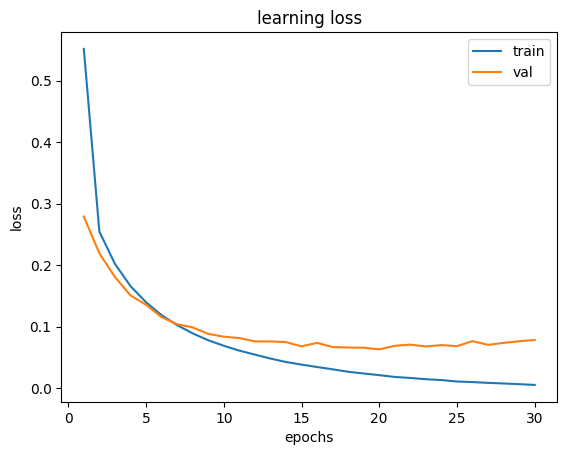

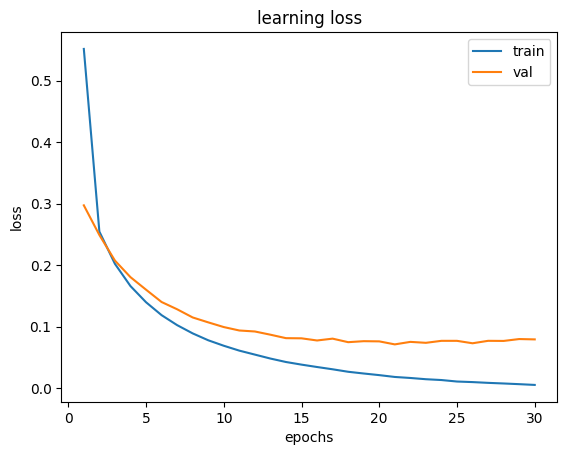

In [12]:
# 결과 시각화
plt.plot(history[:,0], history[:,1],  label="train")
plt.plot(history_[:,0], history_[:,1],  label="val")
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('learning loss')
plt.legend()
plt.show()

plt.plot(history_ActivationSet[:,0], history_ActivationSet[:,1],  label="train")
plt.plot(history__ActivationSet[:,0], history__ActivationSet[:,1],  label="val")
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('learning loss')
plt.legend()
plt.show()


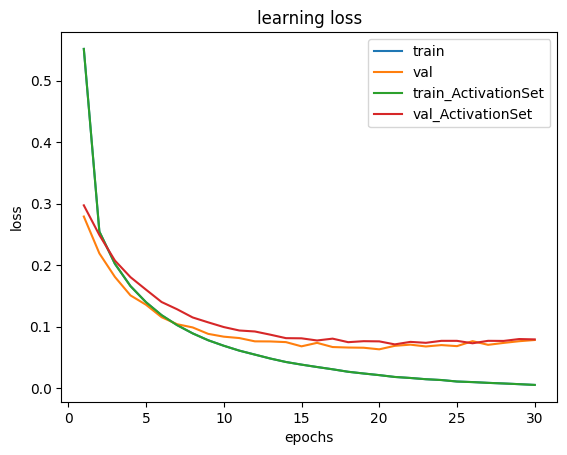

In [13]:
plt.plot(history[:,0], history[:,1],  label="train")
plt.plot(history_[:,0], history_[:,1],  label="val")

plt.plot(history_ActivationSet[:,0], history_ActivationSet[:,1],  label="train_ActivationSet")
plt.plot(history__ActivationSet[:,0], history__ActivationSet[:,1],  label="val_ActivationSet")

plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('learning loss')
plt.legend()
plt.show()